## `Oligopool Calculator` in Action!

**Author** Ayaan Hossain

**Updated** January 18, 2026

This `jupyter` notebook will demonstrate the usage of `Oligopool Calculator` and describe its many functions.

### Content

* [Notebook Setup](#Notebook-Setup)
* [What is Oligopool Calculator?](#What-is-Oligopool-Calculator?)
* [Design Mode Walkthrough](#Design-Mode-Walkthrough)
    * [Simulating the problem](#Simulating-the-problem)
    * [Reviewing constraints and formulating gameplan](#Reviewing-constraints-and-formulating-gameplan)
    * [Primer design review](#Primer-design-review)
    * [Storing the plasmid background](#Storing-the-plasmid-background)
    * [Designing the triple-primer system](#Designing-the-triple-primer-system)
    * [Generating orthogonal barcodes](#Generating-orthogonal-barcodes)
    * [Adding neutral motifs, spacers, and finalizing library](#Adding-neutral-motifs,-spacers,-and-finalizing-library)
    * [Splitting and padding oligos](#Splitting-and-padding-oligos)
* [Analysis Mode Walkthrough](#Analysis-Mode-Walkthrough)
    * [Indexing the barcodes and associated variants](#Indexing-the-barcodes-and-associated-variants)
    * [Packing the NGS reads for quantification](#Packing-the-NGS-reads-for-quantification)
    * [Overview of counting methods](#Overview-of-counting-methods)
    * [Association counting of variants and barcodes](#Association-counting-of-variants-and-barcodes)
    * [Combinatorial barcode counting with callback](#Combinatorial-barcode-counting-with-callback)
* [Conclusion](#Conclusion)

### Notebook Setup

We will need to have `Oligopool Calculator` installed to proceed. You can install it by uncommenting and executing the following cell.

In [1]:
# !pip install oligopool

Let's import `oligopool`.

In [2]:
import oligopool as op

We will need `numpy` to do some math, and we will use `pandas` as our data container.

In [3]:
import numpy  as np
import pandas as pd

We will also need `matplotlib`/`seaborn` for plotting, and `pprint` for pretty printing.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

Finally, we will need `multiprocessing` `Manager` to create a shared dictionary for demonstrating synchronized callback memory during counting.

In [5]:
from multiprocessing import Manager

We're all set.

### What is Oligopool Calculator?

Oligonucleotide pools (oligopools) have revolutionized synthetic biology by enabling large-scale, cost-effective synthesis of hundreds of thousands of unique, short single-stranded DNA sequences.

These oligopools facilitate the creation and study of various biological components, including de novo promoters, ribozymes, protein scaffolds, and CRISPR libraries. Massively parallel reporter assays (MPRAs) are utilized to clone and assess the functionality of these variants using high-throughput next-generation sequencing (NGS), which can generate billions of short reads per experiment.

Looking ahead, advancements are expected in the number and length of oligos, NGS throughput, and reductions in manufacturing costs.

![Oligopool Calculator Workflow](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/workflow.svg)

`Oligopool Calculator` is a comprehensive tool for designing and analyzing large-scale oligonucleotide pools.

In **(a)** `Design Mode`, the algorithms optimize various elements of the oligopool, including barcodes, primers, spacers, and degenerate motifs. It ensures that these components are maximally distinct, non-repetitive, and free from undesired sequences or structures. The tool also enables the splitting of long oligos into shorter fragments with optimized overlaps for downstream assembly.

The **(b)** `Analysis Mode` of `Oligopool Calculator` facilitates the processing of next-generation sequencing (NGS) data derived from barcoded amplicons. This mode allows for efficient mapping of variants and their associated barcodes, producing count matrices for quantitative assessment of variant functionality. Two types of counting operations are supported: Association Counting for assessing synthesis accuracy, and Combinatorial Counting for analyzing multiple barcode combinations from sequencing reads.

Overall `Oligopool Calculator` provides synthetic biologists with a unified platform for oligopool design and characterization, addressing the need for a standardized approach across different projects and labs. This tool eliminates the need for reinventing design scripts or using suboptimal strategies, making it particularly valuable for designing and analyzing pools containing millions of defined variants.

### Design Mode Walkthrough

Suppose we want to design and test a library of 6,232 ribozyme variants based on the following architecture.

![Ribozyme Library Architecture](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/architecture-ribozyme.svg)

To characterize the activity of our library in _E. coli_, we adopt a two-barcode strategy. Because ribozymes are self-cleaving, the two barcodes (BC1 and BC2), placed before and after the core variant, are separated after catalysis. This lets us quantify cleavage by counting the ratio of “separated” to “unseparated” reads.

When using multiple barcode columns, it can also be useful to enforce *cross-set* separation (e.g., ensure BC2 barcodes are also far from the BC1 barcode set), which we will demonstrate later.

#### Simulating the problem

For the purposes of demonstration, let us first generate a random library of 59-73 mers (designing exact ribozymes is beyond the scope here) and assume that the library will be cloned into a 5 kb plasmid backbone for characterization, which we will also generate randomly.

In [6]:
rng = np.random.default_rng(seed=42)

In [7]:
dna = ['A', 'T', 'G', 'C']

In [8]:
ribozymes = []
while len(ribozymes) < 6232:
    variant = ''.join(rng.choice(dna, size=rng.integers(low=59, high=74)))
    if 'GAATTC' in variant or 'GACGTC' in variant:
        # Skipping if random variant has EcoRI or AatII motif
        continue
    ribozymes.append(variant)

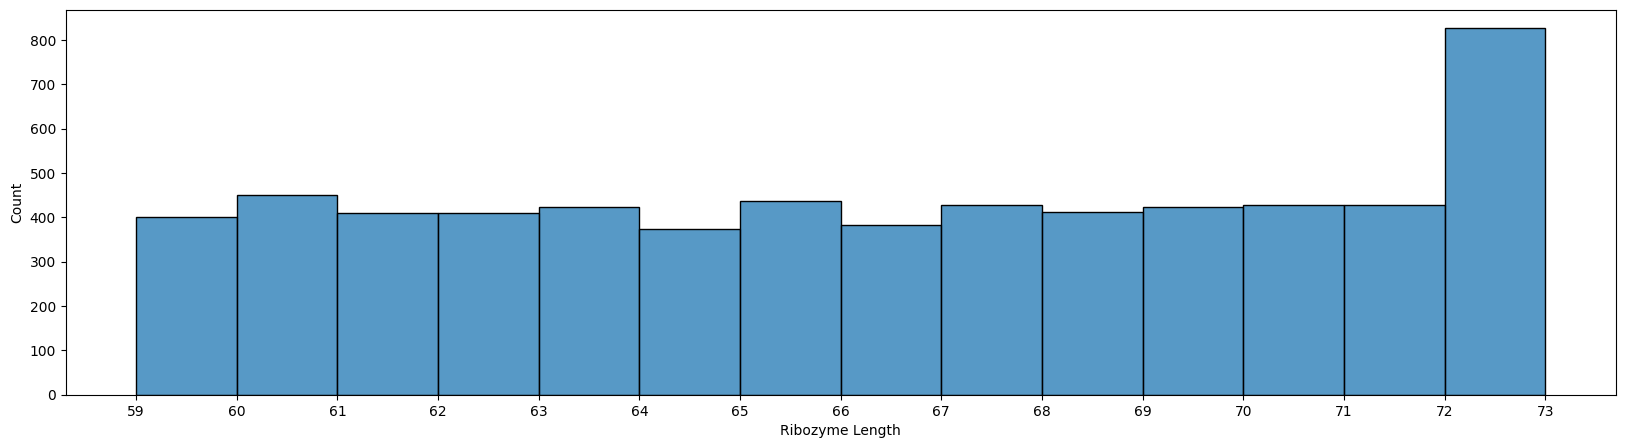

In [9]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.histplot([len(x) for x in ribozymes], binwidth=1)
ax.set_xticks(np.arange(59,74))
ax.set_xlabel('Ribozyme Length')
plt.show()

In [10]:
len(ribozymes)

6232

In [11]:
plasmid = ''.join(rng.choice(dna) for _ in range(5000))

In [12]:
len(plasmid) # 5 kbp long plasmid

5000

#### Reviewing constraints and formulating gameplan

We have generated 6,232 simulated candidates between 59 to 73 bp in length, and a plasmid of length 5 kbp. We want to use `EcoRI` and `AatII` as our restriction sites as part of the characterization process.

We can now use `Oligopool Calculator` to design the following.
* Three primers, each 20bp in length,
* The prefix and suffix barcodes each 11bp in length, and
* Variable length spacers ranging from 3 to 17bp to pad the oligos to 170bp.

As constraints, we aim to have the following.
* The primers should not have off-target binding within the library or to the backbone,
* Addition of primers, barcodes or spacers should not contain `EcoRI` and `AatII` motifs or introduce them at the edges, and
* The barcodes should all have at least 3 mismatches separating each other.

Other realistic constraints, such as exclusion of all palindomic hexamers, or polymeric runs such as `'AAAAA'`, ..., `'CCCC'` may be included as they were in the original projects, but we will skip those for this demonstration. In reality, constaints will depend on the design project.

A useful habit in Design Mode is to measure and QC as we go:

- `lenstat` is a fast length ruler: it reports per-element and per-oligo lengths and remaining free space under an `oligo_length_limit` (it does not modify the input DataFrame).
- `verify` is a broader QC pass (often right before synthesis): it summarizes sequence vs metadata columns, flags degenerate/mixed columns, and checks length overflow + excluded motif emergence.

How do we begin? By asking `help` from `Oligopool Calculator`.

In [13]:
help(op)

Help on package oligopool:

NAME
    oligopool

DESCRIPTION
    oligopool v2026.01.22
    by ah

    Automated design and analysis of oligopool libraries.

    Modules operate on CSV/DataFrames and return (output_df, stats) or stats.
    Chain them to build libraries iteratively; use Patch Mode (`patch_mode=True`)
    to extend existing pools without overwriting prior designs.

    Design Mode
        barcode     orthogonal barcodes with cross-set separation
        primer      thermodynamic primers with Tm matching
        motif       sequence motifs or constant anchors
        spacer      neutral spacers to meet length targets
        background  k-mer database for off-target screening
        split       break long oligos into overlapping fragments
        pad         add primers + Type IIS sites for assembly
        merge       collapse contiguous columns
        revcomp     reverse complement a column range
        lenstat     length statistics and free-space check
        verify 

Per the help, we will need to primarily use the `barcode`, `primer`, and `spacer` modules to add the library elements.

These element modules (`barcode`, `primer`, `motif`, `spacer`) also support **Patch Mode** (`patch_mode=True`), which is designed for iterative workflows:

- If you **append new rows** to an already-designed pool (e.g., you already ordered BC1/primers, then later add new variants), Patch Mode fills only the missing values in an existing output column and leaves existing designs untouched.
- This makes **vertical expansion** safe: you can extend a pool without redesigning (and potentially changing) existing barcodes/primers/anchors/spacers.

In Patch Mode, missing values (e.g., `None`/NaN/empty/`'-'`) are treated as design targets; existing values are sanity-checked (DNA + expected length) but are not re-designed.

#### Primer design review

Generally, primers are the most constrained elements in an oligopool library because they have to follow a desired sequence constraint (such as `5'-GC` clamps), be free of inhibitory structures, be very specific to the library and have minimal off-targeting to background. We recommend designing primers as early as possible, but after all other elements in the library have been finalized, such as any motifs (discussed later in this notebook).

For multiplexed libraries, you can assign per-oligo set labels via `oligo_sets` to design primers independently for each set while ensuring cross-set compatibility. If a paired primer column is supplied, the paired primer is interpreted per set so that each group remains internally matched.


![Primer Design](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/primer.svg)

At any step in the process if we get stuck, `Oligopool Calculator` will tell us what is preventing it from succeeding and we can relax or modify our constraints accordingly.

How do we design primers?

In [14]:
? op.primer

Signature:
 op.primer(
    input_data: str | pandas.core.frame.DataFrame,
    oligo_length_limit: int,
    primer_sequence_constraint: str,
    primer_type: int,
    minimum_melting_temperature: float,
    maximum_melting_temperature: float,
    maximum_repeat_length: int,
    primer_column: str,
    output_file: str | None = None,
    left_context_column: str | None = None,
    right_context_column: str | None = None,
    patch_mode: bool = False,
    oligo_sets: list | str | pandas.core.frame.DataFrame | None = None,
    paired_primer_column: str | None = None,
    excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None,
    background_directory: str | None = None,
    verbose: bool = True,
    random_seed: int | None = None,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Design constrained primers under an IUPAC sequence constraint with Tm/repeat/dimer screening.
Supports background screening, chained primer design via Tm matching, multiplexed per-set prime

Two things should stand out here.

First, primer design involves consideration of background sequences to minimize off-target amplification, such as from the plasmid we set up. We will need to compute this information prior to primer design.

Second, primer design involves consideration of pairing information. If we only had two primers (one forward and one reverse) the order of their design would not matter. But in our problem, there are two forward primers (pink and orange) both of which are coupled to a single reverse primer (yellow). It will be important to design them in the right order, as we will discuss shortly.

Let us first solve the background problem.

#### Storing the plasmid background

`Oligopool Calculator` makes it easy to define a background for primer design via the `background` module.

In [15]:
? op.background

Signature:
 op.background(
    input_data: list | str | pandas.core.frame.DataFrame,
    maximum_repeat_length: int,
    output_directory: str,
    verbose=True,
) -> dict
Docstring:
Build a background k-mer database for screening primer designs against off-target repeat matches.
Use the resulting directory with `primer(..., background_directory=...)`.

Required Parameters:
    - `input_data` (`list` / `str` / `pd.DataFrame`): Background sequences for primers;
        can be a list of DNA strings, a CSV/DataFrame (with 'Sequence' column),
        or a FASTA file (.fa/.fasta/.fna, optionally gzipped).
    - `maximum_repeat_length` (`int`): Max repeat length between primers and background (between 6 and 20).
    - `output_directory` (`str`): Directory to store the generated background k-mer database.

Optional Parameters:
    - `verbose` (`bool`): If `True`, logs updates to stdout (default: `True`).

Returns:
    - A dictionary of stats from the last step in pipeline.

Notes:
    - If `i

> **Note:** If you want to modify the background post-hoc, or want to define your background using a custom strategy, directly use the `vectorDB` module, which behaves like a dictionary. For details use `help(op.vectorDB)`. The `background` module just wraps around it and offers an one-time use simple interface to `vectorDB`.

In [16]:
background_directory = 'demo.oligopool.background' # Path to store our background

Let's remove the background if one exists already, for this demonstration.

In [17]:
! rm -rf $background_directory

Execute the `background` module.

In [18]:
background_stats = op.background(
    input_data=plasmid,
    maximum_repeat_length=8,
    output_directory=background_directory)


[Oligopool Calculator: Design Mode - Background]
                                                  
 Required Arguments
 Background      Data: 1 Unique Sequence(s)
    Maximum    Repeat: Up to 8 Base Pair(s) Background Repeats
     Output Directory: demo.oligopool.background               
                                                 
[Computing Background]
 Sequence 1: TAGCTCAGACGTCGCCTCGA... Inserted
 Time Elapsed: 0.04 sec                       
                        
[Background Statistics]
 Background Status: Successful
      k-mer  Space: 131,072 Unique 9-mers
       Fill  Count:   4,888 Unique 9-mers (  3.73 %)
       Left  Count: 126,184 Unique 9-mers ( 96.27 %) 
 Time Elapsed: 0.05 sec                              



In [19]:
pprint(background_stats)

{'basis': 'solved',
 'input_rows': 1,
 'module': 'background',
 'output_rows': 0,
 'status': True,
 'step': 1,
 'step_name': 'computing-background',
 'vars': {'fill_count': 4888, 'kmer_space': 131072, 'left_count': 126184},
 'warns': {}}


We've now stored the background, and are ready to design the three primers.

> **Note**: All `Oligopool Calculator` functions should return a pipeline statistics dictionary recapitulating the output from the last step performed in the function. If the operation completed successfully, the `status` key will be marked as `True` and `basis` will be marked as `'solved'`.

#### Designing the triple-primer system

All `Design Mode` input and output is mediated through a `pandas` `DataFrame` to facilitate carefully piplined designs. Let us store the variant candidates in a dataframe and start the design process.

In [20]:
df = pd.DataFrame({
    'ID': [f'ribozyme_{x+1:04d}' for x in range(len(ribozymes))],
    'EcoRI': 'GAATTC',
    'Variant':ribozymes,
    'AatII': 'GACGTC',
})

In [21]:
df.tail(5)

,ID,EcoRI,Variant,AatII
6227,ribozyme_6228,GAATTC,GTTTCTTCTTGCAGTGGTCGGGTGAAGGTCGTTGACGGTCTTCACA...,GACGTC
6228,ribozyme_6229,GAATTC,CGAATGCTCAAACCCCGACAGGTTGCTTAGCGTGTTGACAGGTTTT...,GACGTC
6229,ribozyme_6230,GAATTC,CGGCCTAATGCCACGCAGCTTGTCATCTCTGTTAGCGACCATAATT...,GACGTC
6230,ribozyme_6231,GAATTC,TATGTCGAAGACGAATGTGAAAACACAATAACGGTATCGTATGCGA...,GACGTC
6231,ribozyme_6232,GAATTC,GTGTGGAAGAAATAATGAGAGTAGGCAAGTAGGATCACCTTTTGGC...,GACGTC


Given that the primers are coupled, an optimal solution here is to design the innermost (pink) forward primer first, and then design the reverse primer (yellow), followed by designing the outermost (orange) forward primer. This allows all three primers to be compatible with each other.

An alternate solution would involve designing the (yellow) reverse primer first, and then designing the two forward primers successively.

However, if we designed the (yellow) reverse primer at the end, it would be difficult to ensure that it is compatible with both forward primers simultaneously.

In [22]:
# ? op.primer

In [23]:
df, stats = op.primer(
    input_data=df,
    oligo_length_limit=170,                           # Must not exceed 170bp at any stage
    primer_sequence_constraint='SS' + 'N'*18,         # Manually install 5p GC clamp if required
    primer_type=0,                                    # This is a forward primer
    primer_column='PinkForwardPrimer',                # Store designs in 'PinkForwardPrimer' column
    left_context_column='Variant',                    # Next to 'Variant' column
    right_context_column='AatII',                     # Before 'AatII' column
    paired_primer_column=None,                        # No paired primer yet
    excluded_motifs=['GAATTC', 'GACGTC'],             # Ensure EcoRI and AatII do not emerge as motifs
    minimum_melting_temperature=53,                   # Tm = 53°C at least
    maximum_melting_temperature=55,                   # Tm = 55°C at most
    maximum_repeat_length=10,                         # No more than 10-mer repeats allowed
    background_directory=background_directory,        # As setup before
    output_file=None)                                 # In-memory return, no CSV written here


[Oligopool Calculator: Design Mode - Primer]
                                              
 Required Arguments
      Input Data       : DataFrame w/ 6,232 Record(s)
      Oligo Limit      : At most 170 Base Pair(s)     
     Primer Sequence   : A 20 Base Pair IUPAC Constraint
     Primer Type       : Forward Primer Design           
    Melting Temperature: 53 to 55 °C           
     Repeat Length     : Up to 10 Base Pair(s) Oligopool Repeats
     Primer Column     : Output in Column 'PinkForwardPrimer'    
     Output File       : In-Memory DataFrame                  
                                             
 Optional Arguments
       Left Context    : Input from Column 'Variant'
      Right Context    : Input from Column 'AatII'   
      Patch Mode       : Disabled (Design All Primers)
      Oligo Sets       : None Specified                
     Paired Primer     : None Specified 
   Excluded Motifs     : 2 Unique Motif(s)
 Background Database   : Contains 4,888 Unique 9-mers

The designed primer is predicted to be free from hairpin structures with low homodimer probability.

Let us now design the two remaining primers in silent mode.

In [24]:
df, _ = op.primer(
    input_data=df,                                   # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='N'*18 + 'WW',        # Manually install 3p AT clamp if needed
    primer_type=1,                                   # This is a reverse primer
    primer_column='YellowReversePrimer',             # Store designs in 'YellowReversePrimer' column
    left_context_column='PinkForwardPrimer',         # Next to 'PinkForwardPrimer' column
    right_context_column='AatII',                    # Before 'AatII' column
    paired_primer_column='PinkForwardPrimer',        # Yellow reverse primer paired with pink forward primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=10,
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    verbose=False)                               # Silent Mode

In [25]:
df, _ = op.primer(
    input_data=df,                                    # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='N'*20,
    primer_type=0,                                    # This is a forward primer
    primer_column='OrangeForwardPrimer',              # Store designs in 'OrangeForwardPrimer' column
    left_context_column='EcoRI',                      # Next to 'EcoRI' column
    right_context_column='Variant',                   # Before 'Variant' column
    paired_primer_column='YellowReversePrimer',       # Orange forward primer paired with yellow reverse primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=10,
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    verbose=False)

In [26]:
df.head(5)

,ID,EcoRI,OrangeForwardPrimer,Variant,PinkForwardPrimer,YellowReversePrimer,AatII
0,ribozyme_0001,GAATTC,GGCGTTACTGAGATGCACAT,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GCAATCCTTACCACCCCGAA,ATTCGCCTACGTGTGACCTT,GACGTC
1,ribozyme_0002,GAATTC,GGCGTTACTGAGATGCACAT,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GCAATCCTTACCACCCCGAA,ATTCGCCTACGTGTGACCTT,GACGTC
2,ribozyme_0003,GAATTC,GGCGTTACTGAGATGCACAT,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GCAATCCTTACCACCCCGAA,ATTCGCCTACGTGTGACCTT,GACGTC
3,ribozyme_0004,GAATTC,GGCGTTACTGAGATGCACAT,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GCAATCCTTACCACCCCGAA,ATTCGCCTACGTGTGACCTT,GACGTC
4,ribozyme_0005,GAATTC,GGCGTTACTGAGATGCACAT,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GCAATCCTTACCACCCCGAA,ATTCGCCTACGTGTGACCTT,GACGTC


All our primers are installed. Barcodes up next!

Before that, since we're done with the background let's drop it.

In [27]:
# help(op.vectorDB)

In [28]:
op.vectorDB(background_directory, maximum_repeat_length=None).drop()

True

#### Generating orthogonal barcodes

Barcodes are critical elements that help identify each variant uniquely, especially when the core oligo variants are similar to each other. `Oligopool Calculator` maximizes barcode distinguishability which is useful, for example, when the library is exploring all single substitutions to a template.

![Barcode Design](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/barcode.svg)

In [29]:
? op.barcode

Signature:
 op.barcode(
    input_data: str | pandas.core.frame.DataFrame,
    oligo_length_limit: int,
    barcode_length: int,
    minimum_hamming_distance: int,
    maximum_repeat_length: int,
    barcode_column: str,
    output_file: str | None = None,
    barcode_type: int = 0,
    left_context_column: str | None = None,
    right_context_column: str | None = None,
    patch_mode: bool = False,
    cross_barcode_columns: list[str] | None = None,
    minimum_cross_distance: int | None = None,
    excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None,
    verbose: bool = True,
    random_seed: int | None = None,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Design per-variant barcodes under Hamming-distance, repeat, and excluded-motif constraints, with
optional context screening and cross-set separation against existing barcode columns.

Required Parameters:
    - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligo

Unlike primers which need to satisfy global constraints (a hard problem), barcodes are optimized contextually. So, barcodes may be designed after all the primers have been installed. However, the pairwise Hamming distance requirement coupled with other constraints makes it difficult to judge ahead of time if there are enough barcodes possible for a given library with desired constraints.

Let us design BC1 first.

In [30]:
df.columns

Index(['ID', 'EcoRI', 'OrangeForwardPrimer', 'Variant', 'PinkForwardPrimer',
       'YellowReversePrimer', 'AatII'],
      dtype='object')

In [31]:
df, _ = op.barcode(
    input_data=df,
    oligo_length_limit=170,
    barcode_length=11,
    minimum_hamming_distance=3,  # As defined by our goal
    maximum_repeat_length=6,     # To prevent internal hairpins, say
    barcode_column='BC1',
    barcode_type=1,
    left_context_column='OrangeForwardPrimer',
    right_context_column='Variant',
    excluded_motifs=['GAATTC', 'GACGTC'])


[Oligopool Calculator: Design Mode - Barcode]
                                               
 Required Arguments
      Input Data    : DataFrame w/ 6,232 Record(s)
      Oligo Limit   : At most 170 Base Pair(s)     
    Barcode Length  : Exactly 11 Base Pair(s)  
    Hamming Distance: At least 3 Mismatch(es) per Barcode Pair
     Repeat Length  : Up to 6 Base Pair(s) Oligopool Repeats   
    Barcode Column  : Output in Column 'BC1'                 
     Output File    : In-Memory DataFrame    
                                          
 Optional Arguments
    Barcode Type    : Spectrum Optimized Barcodes
       Left Context : Input from Column 'OrangeForwardPrimer'
      Right Context : Input from Column 'Variant'             
      Patch Mode    : Disabled (Design All Barcodes)
      Cross Barcodes: None Specified                 
      Cross Distance: None Specified 
   Excluded Motifs  : 2 Unique Motif(s)
                                        
[Step 1: Parsing Oligo Limit]
 Maxi

Most of the barcodes have at least 4 mismatches separating them, and all of them are at least 3 mismatches apart as intended.

Next, let's add BC2.

**Cross-barcode sets (optional):** When designing multiple barcode columns (BC1, BC2, ...), you may want each new barcode set to be separated not only within itself (`minimum_hamming_distance`), but also from existing barcode sets.

`cross_barcode_columns` + `minimum_cross_distance` enforce a *global* cross-set Hamming distance between each newly designed barcode and the union of barcodes in the specified column(s) (not a per-row pairing constraint).

Below, BC2 is designed to be ≥3 mismatches away from every BC1 sequence. For a third barcode, you could use `cross_barcode_columns=['BC1','BC2']`.

In [32]:
df, _ = op.barcode(
    input_data=df,
    oligo_length_limit=170,
    barcode_length=11,
    minimum_hamming_distance=3,
    maximum_repeat_length=6,
    barcode_column='BC2',
    barcode_type=1,
    left_context_column='PinkForwardPrimer',
    right_context_column='YellowReversePrimer',
    excluded_motifs=['GAATTC', 'GACGTC'],
    cross_barcode_columns=['BC1'],
    minimum_cross_distance=3,
    verbose=False)  # Silent mode

In [33]:
df.head(5)

,ID,EcoRI,OrangeForwardPrimer,BC1,Variant,PinkForwardPrimer,BC2,YellowReversePrimer,AatII
0,ribozyme_0001,GAATTC,GGCGTTACTGAGATGCACAT,GAAAAACTTGC,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GCAATCCTTACCACCCCGAA,CCCCCCGCTAT,ATTCGCCTACGTGTGACCTT,GACGTC
1,ribozyme_0002,GAATTC,GGCGTTACTGAGATGCACAT,CGAACGGGTAG,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GCAATCCTTACCACCCCGAA,CACCCCATGGT,ATTCGCCTACGTGTGACCTT,GACGTC
2,ribozyme_0003,GAATTC,GGCGTTACTGAGATGCACAT,AGACGCCCACA,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GCAATCCTTACCACCCCGAA,TCAAAACGTTG,ATTCGCCTACGTGTGACCTT,GACGTC
3,ribozyme_0004,GAATTC,GGCGTTACTGAGATGCACAT,TTGACTCCCGC,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GCAATCCTTACCACCCCGAA,GCCTGATGTCG,ATTCGCCTACGTGTGACCTT,GACGTC
4,ribozyme_0005,GAATTC,GGCGTTACTGAGATGCACAT,CCCGCTTCCTG,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GCAATCCTTACCACCCCGAA,TGGCCTTTAAT,ATTCGCCTACGTGTGACCTT,GACGTC


Barcodes are done! The only thing left to design are the spacers so that all oligos have the same length of 170 bp.

Before designing spacers, we first measure how much length budget is left. The `lenstat` module is a quick ruler: it reports per-element lengths and remaining free space, without modifying the DataFrame.

In [34]:
# help(op.lenstat)

In [35]:
length_stats = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element AatII: Occupies 6 Base Pair(s)               
 Time Elapsed: 0.02 sec
                        
[Length Statistics]

                         Min     Max    Min    Max    Oligo
                     Element Element  Oligo  Oligo    Limit
                      Length  Length Length Length Overflow
               EcoRI    6 bp    6 bp   6 bp   6 bp       No
 OrangeForwardPrimer   20 bp   20 bp  26 bp  26 bp       No
                 BC1   11 bp   11 bp  37 bp  37 bp       No
             Variant   59 bp   73 bp  96 bp 110 bp       No
   PinkForwardPrimer   20 bp   20 bp 116 bp 130 bp       No
                 BC2   11 bp   11 bp 127 bp 141 bp       No
 YellowReversePrimer   20 bp   20 b

#### Adding neutral motifs, spacers, and finalizing library

In [36]:
df.columns

Index(['ID', 'EcoRI', 'OrangeForwardPrimer', 'BC1', 'Variant',
       'PinkForwardPrimer', 'BC2', 'YellowReversePrimer', 'AatII'],
      dtype='object')

The last element in our oligo is an `AatII` restriction site, and we want to add 3 to 17 bases of filler next to it. We can do this using the `spacer` module.

But suppose we wanted to add a fixed length spacer site based on a degenerate sequence constraint, such as a motif? We would use the `motif` module instead. One way to think about this is that spacers are a more general form of motifs -- motifs are more constrained in terms of sequence composition and are of fixed length.

Another important use of the `motif` module is in designing constant barcode anchors that is distinct from the remainder of the oligos (controlled via `maximum_repeat_length` parameter) to facilate downstream counting.

In [37]:
? op.motif

Signature:
 op.motif(
    input_data: str | pandas.core.frame.DataFrame,
    oligo_length_limit: int,
    motif_sequence_constraint: str,
    maximum_repeat_length: int,
    motif_column: str,
    output_file: str | None = None,
    motif_type: int = 0,
    left_context_column: str | None = None,
    right_context_column: str | None = None,
    patch_mode: bool = False,
    excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None,
    verbose: bool = True,
    random_seed: int | None = None,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Design or insert motifs under an IUPAC sequence constraint with repeat/excluded-motif screening.
Supports per-variant motifs and constant anchors (`motif_type=1`) for building indexable architectures.

Required Parameters:
    - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
    - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
    - `motif_sequence_co

We will see this function in action by first removing the `AatII` motif column and replacing it with a degenerate motif containing the constant restriction site embedded in it but with 3 `'N'`s on its right flank.

In [38]:
df = df.drop(columns=['AatII'])

In [39]:
df.columns

Index(['ID', 'EcoRI', 'OrangeForwardPrimer', 'BC1', 'Variant',
       'PinkForwardPrimer', 'BC2', 'YellowReversePrimer'],
      dtype='object')

In [40]:
df, _ = op.motif(
    input_data=df,
    oligo_length_limit=170,
    motif_sequence_constraint='GACGTC'+'NNN', # The AatII motif with right flanking Ns
    maximum_repeat_length=6,
    motif_column='AatIIPadded',
    left_context_column='YellowReversePrimer',
    right_context_column=None,
    excluded_motifs=['GAATTC', 'GACGTC'])     # Notice how we are still forbidding the emergence of AatII here


[Oligopool Calculator: Design Mode - Motif]
                                             
 Required Arguments
      Input Data    : DataFrame w/ 6,232 Record(s)
      Oligo Limit   : At most 170 Base Pair(s)     
      Motif Sequence: A 9 Base Pair IUPAC Constraint
     Repeat Length  : Up to 6 Base Pair(s) Oligopool Repeats
      Motif Column  : Output in Column 'AatIIPadded'         
     Output File    : In-Memory DataFrame            
                                          
 Optional Arguments
      Motif Type    : Non-Constant Motifs
       Left Context : Input from Column 'YellowReversePrimer'
      Right Context : None Specified                          
      Patch Mode    : Disabled (Design All Motifs)
   Excluded Motifs  : 2 Unique Motif(s)            
                                        
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
   Input Oligo Length:  147 to 161 Base Pair(s)
   Reqd. Motif Length:    9 Base Pair(s)        
 Free Space Av

Step 3 in the `motif` pipeline warned us about the presence of `'GACGTC'` in our constraint itself. Nevertheless, the design step was successful.

In [41]:
length_stats = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element AatIIPadded: Occupies 9 Base Pair(s)         
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                         Min     Max    Min    Max    Oligo
                     Element Element  Oligo  Oligo    Limit
                      Length  Length Length Length Overflow
               EcoRI    6 bp    6 bp   6 bp   6 bp       No
 OrangeForwardPrimer   20 bp   20 bp  26 bp  26 bp       No
                 BC1   11 bp   11 bp  37 bp  37 bp       No
             Variant   59 bp   73 bp  96 bp 110 bp       No
   PinkForwardPrimer   20 bp   20 bp 116 bp 130 bp       No
                 BC2   11 bp   11 bp 127 bp 141 bp       No
 YellowReversePrimer   20 bp   20 b

We can now use the `spacer` module to pad the oligos to 170 bases. Free space available is between 0 to 14 bases.

In [42]:
? op.spacer

Signature:
 op.spacer(
    input_data: str | pandas.core.frame.DataFrame,
    oligo_length_limit: int,
    maximum_repeat_length: int,
    spacer_column: str,
    output_file: str | None = None,
    spacer_length: int | list | str | pandas.core.frame.DataFrame | None = None,
    left_context_column: str | None = None,
    right_context_column: str | None = None,
    patch_mode: bool = False,
    excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None,
    verbose: bool = True,
    random_seed: int | None = None,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Insert neutral spacer DNA under repeat/excluded-motif constraints.
Spacer length can be fixed, per-row, or auto-sized to match `oligo_length_limit`.

Required Parameters:
    - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
    - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
    - `maximum_repeat_length` (`int`): Max shared repe

`Oligopool Calculator` can flexibly design our variable length spacers. Here our aim is to add a spacer so that the final oligo length is 170 bases, and we can achieve this by simply specifying the `oligo_length_limit` and using `None` as our `spacer_length` argument. Otherwise, we could specify the length of each spacer, in order, per oligo in a list or a DataFrame.

In [43]:
df, _ = op.spacer(
    input_data=df,
    oligo_length_limit=170,
    spacer_length=None,    # Using None, we will automatically add spacers to match oligo_length_limit
    maximum_repeat_length=6,
    spacer_column='Spacer',
    left_context_column='AatIIPadded',
    right_context_column=None,
    excluded_motifs=['GAATTC', 'GACGTC'],
    verbose=True)


[Oligopool Calculator: Design Mode - Spacer]
                                              
 Required Arguments
      Input Data   : DataFrame w/ 6,232 Record(s)
      Oligo Limit  : At most 170 Base Pair(s)     
     Repeat Length : Up to 6 Base Pair(s) Oligopool Repeats
     Spacer Column : Output in Column 'Spacer'              
     Output File   : In-Memory DataFrame       
                                         
 Optional Arguments
     Spacer Length : Computed from Oligo Length (Auto-Inferred)
       Left Context: Input from Column 'AatIIPadded'            
      Right Context: None Specified                  
      Patch Mode   : Disabled (Design All Spacers)
   Excluded Motifs : 2 Unique Motif(s)             
                                       
[Step 1: Extracting Spacer Length]
 Variant ribozyme_6232: Allows 10 Base Pair Spacer
 Time Elapsed: 2.70 sec
                        
[Step 2: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
   Input Oligo Length: 

In [44]:
length_stats = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element Spacer: Occupies 0 to 14 Base Pair(s)        
 Time Elapsed: 0.02 sec
                        
[Length Statistics]

                         Min     Max    Min    Max    Oligo
                     Element Element  Oligo  Oligo    Limit
                      Length  Length Length Length Overflow
               EcoRI    6 bp    6 bp   6 bp   6 bp       No
 OrangeForwardPrimer   20 bp   20 bp  26 bp  26 bp       No
                 BC1   11 bp   11 bp  37 bp  37 bp       No
             Variant   59 bp   73 bp  96 bp 110 bp       No
   PinkForwardPrimer   20 bp   20 bp 116 bp 130 bp       No
                 BC2   11 bp   11 bp 127 bp 141 bp       No
 YellowReversePrimer   20 bp   20 b

Our library is complete, all elements have been added, and the oligos are all 170 bases. Let's finalize our library using the `final` module.

In [45]:
# ? op.final

In [46]:
final_df, _ = op.final(input_data=df)


[Oligopool Calculator: Design Mode - Final]
                                             
 Required Arguments
  Input Data: DataFrame w/ 6,232 Record(s)
 Output File: In-Memory DataFrame          
                                  
[Step 1: Finalizing Oligopool]
 Finalization Completed         
 Time Elapsed: 0.01 sec 
                        
[Finalization Statistics]
 Final Status: Successful  
 Oligo Length: 170 Base Pair(s)
 Time Elapsed: 0.01 sec         



In [47]:
final_df.head(5)

,ID,CompleteOligo,OligoLength
0,ribozyme_0001,GAATTCGGCGTTACTGAGATGCACATGAAAAACTTGCCGTTCAGAA...,170
1,ribozyme_0002,GAATTCGGCGTTACTGAGATGCACATCGAACGGGTAGTCTTCTATC...,170
2,ribozyme_0003,GAATTCGGCGTTACTGAGATGCACATAGACGCCCACAGCTGATTCA...,170
3,ribozyme_0004,GAATTCGGCGTTACTGAGATGCACATTTGACTCCCGCCATATCTCT...,170
4,ribozyme_0005,GAATTCGGCGTTACTGAGATGCACATCCCGCTTCCTGGCATCCGTT...,170


> **Note** All annotations of the individual oligos are lost in this step. So, we saved it to a new DataFrame. In general, it is a good idea to store the result of each step in `Design Mode` to separate DataFrame variables if we were designing our pools interactively, and wanted to roll back.

Using the `final` module produces a DataFrame that needs to be passed along for synthesis. `Design Mode` functions should no longer be applied on it.

Before shipping the library for synthesis, it is useful to run a quick QC pass. Compared to `lenstat`, the `verify` module is broader: it summarizes the architecture and length distribution, inspects column types (sequence vs metadata), and checks that excluded motifs did not re-emerge beyond their intended occurrence.

It also flags degenerate/IUPAC sequence columns (e.g., UMIs) so you can confirm they are intentional.

In [48]:
? op.verify

Signature:
 op.verify(
    input_data: str | pandas.core.frame.DataFrame,
    oligo_length_limit: int | None = None,
    excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None,
    verbose: bool = True,
) -> dict
Docstring:
Lightweight QC for an oligopool DataFrame (column inspection, length stats, and excluded-motif
emergence), without modifying data or writing outputs.

Required Parameters:
    - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with an 'ID' column.

Optional Parameters:
    - `oligo_length_limit` (`int` / `None`): If provided, check for length overflow (default: `None`).
    - `excluded_motifs` (`list` / `str` / `pd.DataFrame` / `None`): Motifs to track; can be a CSV path
      or DataFrame with an 'Exmotif' column (default: `None`).
    - `verbose` (`bool`): If `True`, log updates to stdout (default: `True`).

Returns:
    - A dictionary of verification results (stats only; no DataFrame is returned).

Notes:
    - Column inspec

In [49]:
verify_stats = op.verify(
    input_data=final_df,
    oligo_length_limit=170,
    excluded_motifs=['GAATTC', 'GACGTC'],
    verbose=False)
verify_stats['status']

True

We can also explicitly check for any violation of our motif constraints. For example, in all our designed oligos there should only be single occurrences of the `EcoRI` and `AatII` motifs at their respective location.

In [50]:
assert final_df.CompleteOligo.transform(lambda x: x.count('GAATTC')).values.max() == 1

In [51]:
assert final_df.CompleteOligo.transform(lambda x: x.count('GACGTC')).values.max() == 1

#### Splitting and padding oligos

Sometimes the oligos may be longer than can be synthesized. One way to solve this problem is to use the `split` module to split such long oligos into shorter overlapping fragments. Individual sets of fragments can be padded appropriately using the `pad` module for downstream assembly. Treat each `SplitN` column as a separate synthesis pool: run `pad` once per split column, then `final` each padded DataFrame (don't run `final` on the raw multi-column `split` output). If you prefer one DataFrame per fragment, enable `separate_outputs` (CLI `op split` writes separate files by default).

![Splitting and Padding](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/assembly.svg)

In [52]:
? op.split

Signature:
 op.split(
    input_data: str | pandas.core.frame.DataFrame,
    split_length_limit: int,
    minimum_melting_temperature: float,
    minimum_hamming_distance: int,
    minimum_overlap_length: int,
    maximum_overlap_length: int,
    output_file: str | None = None,
    verbose: bool = True,
    random_seed: int | None = None,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Split long oligos into overlapping fragments for downstream assembly, choosing overlaps that meet
Tm and distance constraints. Returns a DataFrame containing `Split1`, `Split2`, ... columns.

Required Parameters:
    - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
    - `split_length_limit` (`int`): Maximum allowed length for split oligos (≥ 4).
    - `minimum_melting_temperature` (`float`): Minimum overlap region Tm (≥ 4°C).
    - `minimum_hamming_distance` (`int`): Minimum overlap region pairwise Hamming distance (≥ 1).
    - `minimum

We will pretend that our 170 bp oligos from above are slightly longer than can be synthesized successfully in a pool where each oligo can be at most 150 bp long.

Our goal then is to fragment the oligos so that each fragment is at most 110 bases with 40 to 60 base overlap across the fragments. We will leave 40 bases, 20 bp each for the two terminal padding primers.

In [53]:
split_df, _ = op.split(
    input_data=df,          # Notice, we are not using the "final_df"
    split_length_limit=110, # Each split must be at most 110 bases long
    minimum_melting_temperature=55, # Assembly Tm is 55°C
    minimum_hamming_distance=5,     # Ensure the overlaps are distinct
    minimum_overlap_length=40,    # At least 40 bp overlap
    maximum_overlap_length=60)    # At most 60 bp overlap


[Oligopool Calculator: Design Mode - Split]
                                             
 Required Arguments
   Input Data       : DataFrame w/ 6,232 Record(s)
   Split Limit      : Split Fragments at most 110 Base Pair(s) Each
 Melting Temperature: At least 55 °C b/w On-Target Overlaps         
 Hamming Distance   : At least 5 Mismatch(es) per Off-Target Overlap Pair 
 Overlap Length     : 40 to 60 Base Pair(s) Fragment Overlap(s)            
  Output File       : In-Memory DataFrame                       
                                          
[Step 1: Parsing Split Limit]
   Input Oligo Length: 170 Base Pair(s)
 Split Fragment Count: At least 2 Split(s) per Variant
 Time Elapsed: 0.01 sec                                
 Verdict: Splitting Possibly Feasible
                                      
[Step 2: Computing Sequence Matrix]
   Vectorized: 6,232 Sequences                                                 
   3' Padding:     0 Base Pair(s)
 Time Elapsed: 4.47 sec           

In [54]:
split_df.head(5)

,ID,Split1,Split2
0,ribozyme_0001,GAATTCGGCGTTACTGAGATGCACATGAAAAACTTGCCGTTCAGAA...,TCACTATTGCGGAGGTGACGTCAAGGTCACACGTAGGCGAATATAG...
1,ribozyme_0002,GAATTCGGCGTTACTGAGATGCACATCGAACGGGTAGTCTTCTATC...,CACGGTGACGTCAAGGTCACACGTAGGCGAATACCATGGGGTGTTC...
2,ribozyme_0003,GAATTCGGCGTTACTGAGATGCACATAGACGCCCACAGCTGATTCA...,TCACTATTGCGGACCGGACGTCAAGGTCACACGTAGGCGAATCAAC...
3,ribozyme_0004,GAATTCGGCGTTACTGAGATGCACATTTGACTCCCGCCATATCTCT...,ACATAGAGTGGTGACGTCAAGGTCACACGTAGGCGAATCGACATCA...
4,ribozyme_0005,GAATTCGGCGTTACTGAGATGCACATCCCGCTTCCTGGCATCCGTT...,AAAAAACGCGTGGGTGACGTCAAGGTCACACGTAGGCGAATATTAA...


In [55]:
length_stats = op.lenstat(input_data=split_df, oligo_length_limit=150);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 150 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element Split2: Occupies 100 Base Pair(s)
 Time Elapsed: 0.00 sec
                        
[Length Statistics]

            Min     Max    Min    Max    Oligo
        Element Element  Oligo  Oligo    Limit
         Length  Length Length Length Overflow
 Split1  110 bp  110 bp 110 bp 110 bp       No
 Split2  100 bp  100 bp 210 bp 210 bp      Yes
                     
 Free Space Available: -60 Base Pair(s)
 Time Elapsed: 0.01 sec                  



We have automatically split our library for two-fragment assembly. The first pool contains 110 bp oligos while the oligos in the second pool are shorter.

The split fragments are in PCR assembly order, meaning the first fragment and the second fragments are returned in opposite strands, so that PCR generates the correct full-length double-stranded oligos. We can verify this using the `revcomp` module to change the orientation of `'Split2'` column and see that the ends of `'Split1'` sequences overlap with the beginning of the sequences in `'Split2'` column.

**Tip (not demoed):** Use `merge` to collapse a column range into a single DNA element before other operations.

This is helpful when a multi-column region (e.g., `ForwardPrimer` + `BC1` + `Variant` + `BC2`) should be treated as one contiguous sequence for downstream steps like `revcomp` or `final`.

Learn more: run `help(op.merge)` (or `? op.merge`) in this notebook.

In [56]:
# help(op.revcomp)

In [57]:
check_df, _ = op.revcomp(
    input_data=split_df,
    left_context_column='Split2',
    right_context_column='Split2',
    verbose=False)

In [58]:
check_df.head(1)

,ID,Split1,Split2
0,ribozyme_0001,GAATTCGGCGTTACTGAGATGCACATGAAAAACTTGCCGTTCAGAA...,CACCTGACGTACTCGCCATTTAGAGGCGCAATCCTTACCACCCCGA...


In [59]:
split1 = check_df.head(1).Split1.values[0]
split2 = check_df.head(1).Split2.values[0]

In [60]:
for i in range(max(len(split1), len(split2)), 0, -1):
    if split1[-i:] == split2[:i]:
        alignment_padding = len(split1) - i
        print(split1)
        print(' ' * alignment_padding + '|' * i)
        print(' ' * alignment_padding + split2)
        break
else:
    print('No overlap between computed splits!')

GAATTCGGCGTTACTGAGATGCACATGAAAAACTTGCCGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACTCGCCATTTAGAGGCGCAATCCTTACCA
                                                                      ||||||||||||||||||||||||||||||||||||||||
                                                                      CACCTGACGTACTCGCCATTTAGAGGCGCAATCCTTACCACCCCGAACCCCCCGCTATATTCGCCTACGTGTGACCTTGACGTCACCTCCGCAATAGTGA


The `pad` module allows designing of padded primers with embedded Type IIS restriction sites to amplify the oligo fragments, convert them to double-stranded DNA (assuming synthesized oligos are ssDNA) and enable scarless assembly downstream.

In [61]:
? op.pad

Signature:
 op.pad(
    input_data: str | pandas.core.frame.DataFrame,
    oligo_length_limit: int,
    split_column: str,
    typeIIS_system: str,
    minimum_melting_temperature: float,
    maximum_melting_temperature: float,
    maximum_repeat_length: int,
    output_file: str | None = None,
    verbose: bool = True,
    random_seed: int | None = None,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Pad split fragments with paired primers (embedding a chosen 3' Type IIS site) plus optional
spacers to meet `oligo_length_limit`. Produces an assembly-ready pad layout suitable for `final`.

Required Parameters:
    - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
    - `oligo_length_limit` (`int`): Maximum allowed padded oligo length (≥ 60).
    - `split_column` (`str`): Column name containing split fragments.
    - `typeIIS_system` (`str`): Type IIS restriction enzyme to be used for pad excision. See notes.
    - `mini

We will design our pads with `'BsaI'`, as an example.

In [62]:
first_pad_df, _ = op.pad(
    input_data=split_df,
    oligo_length_limit=150, # Recall, we are pretending 150 bp synthesis limit
    split_column='Split1',  # We will pad the first fragment
    typeIIS_system='BsaI',  # Pad with internal 3' BsaI motif
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=10)


[Oligopool Calculator: Design Mode - Pad]
                                           
 Required Arguments
   Input Data       : DataFrame w/ 6,232 Record(s)
   Oligo Limit      : Design 150 Base Pair(s) Padded Oligos
   Split Column     : Input from Column 'Split1'            
 TypeIIS System     : Enzyme 'BsaI' Recognizing Motif 'GGTCTC'
 Melting Temperature: 53 to 55 °C                              
  Repeat Length     : Up to 10 Base Pair(s) Oligopool Repeats
  Output File       : In-Memory DataFrame                     
                                          
[Step 1: Parsing Split Column]
 Split Fragments: 6,232 Unique Sequences(s)
 Fragment Length: 110 Base Pair(s)          
 Time Elapsed: 0.00 sec            
 Verdict: Pad Design Possibly Feasible
                                       
[Step 2: Parsing TypeIIS System]
 Minimum Padding:  40 bp due to 110 bp Fragment(s)
 Maximum Padding:  40 bp due to 110 bp Fragment(s) 
 TypeIIS System : Requires 34 bp Minimum Padding   
 Ti

In [63]:
op.lenstat(input_data=first_pad_df, oligo_length_limit=150);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 150 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element 3primeSpacer: Occupies 0 Base Pair(s)  
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                   Min     Max    Min    Max    Oligo
               Element Element  Oligo  Oligo    Limit
                Length  Length Length Length Overflow
  5primeSpacer    0 bp    0 bp   0 bp   0 bp       No
 ForwardPrimer   20 bp   20 bp  20 bp  20 bp       No
        Split1  110 bp  110 bp 130 bp 130 bp       No
 ReversePrimer   20 bp   20 bp 150 bp 150 bp       No
  3primeSpacer    0 bp    0 bp 150 bp 150 bp       No
                     
 Free Space Available: 0 Base Pair(s)
 Time Elapsed: 0.01 sec                



Looks good. On to the second padding.

In [64]:
second_pad_df, _ = op.pad(
    input_data=split_df,
    oligo_length_limit=150,
    split_column='Split2',  # We will pad the second fragment now
    typeIIS_system='BsaI',
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=10,
    verbose=False)  # Silent Mode

In [65]:
second_pad_df.head(5)

,ID,5primeSpacer,ForwardPrimer,Split2,ReversePrimer,3primeSpacer
0,ribozyme_0001,AAA,GGTAACGTAAAGGTCTCGGGTA,TCACTATTGCGGAGGTGACGTCAAGGTCACACGTAGGCGAATATAG...,ATTTTGAGACCCCCCAGATACC,TCG
1,ribozyme_0002,AAA,GGTAACGTAAAGGTCTCGGGTA,CACGGTGACGTCAAGGTCACACGTAGGCGAATACCATGGGGTGTTC...,ATTTTGAGACCCCCCAGATACC,TCG
2,ribozyme_0003,AAA,GGTAACGTAAAGGTCTCGGGTA,TCACTATTGCGGACCGGACGTCAAGGTCACACGTAGGCGAATCAAC...,ATTTTGAGACCCCCCAGATACC,TCG
3,ribozyme_0004,AAA,GGTAACGTAAAGGTCTCGGGTA,ACATAGAGTGGTGACGTCAAGGTCACACGTAGGCGAATCGACATCA...,ATTTTGAGACCCCCCAGATACC,TCG
4,ribozyme_0005,AAA,GGTAACGTAAAGGTCTCGGGTA,AAAAAACGCGTGGGTGACGTCAAGGTCACACGTAGGCGAATATTAA...,ATTTTGAGACCCCCCAGATACC,TCG


In [66]:
op.lenstat(input_data=second_pad_df, oligo_length_limit=150);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 150 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element 3primeSpacer: Occupies 3 Base Pair(s)  
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                   Min     Max    Min    Max    Oligo
               Element Element  Oligo  Oligo    Limit
                Length  Length Length Length Overflow
  5primeSpacer    3 bp    3 bp   3 bp   3 bp       No
 ForwardPrimer   22 bp   22 bp  25 bp  25 bp       No
        Split2  100 bp  100 bp 125 bp 125 bp       No
 ReversePrimer   22 bp   22 bp 147 bp 147 bp       No
  3primeSpacer    3 bp    3 bp 150 bp 150 bp       No
                     
 Free Space Available: 0 Base Pair(s)
 Time Elapsed: 0.01 sec                



We would now finalize both the padded DataFrames and ship it to our provider for synthesis.

This concludes our `Oligopool Calculator` `Design Mode` walkthrough.

### Analysis Mode Walkthrough

Let us consider the following ribozyme system architecture again.

![Ribozyme Library Architecture](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/architecture-ribozyme.svg)

In our `Design Mode` walkthrough we designed a pool of over 6,000 simulated ribozyme variants. One characterization approach may involve sequencing an amplicon spanning `OrangeForwardPrimer` to `YellowReversePrimer` for uncleaved products, while a second sequencing of cleaved products spans `PinkForwardPrimer` through `YellowReversePrimer`. The ratio of cleaved to uncleaved products would give us the cleavage rate quntification for a ribozyme variant.

`Oligopool Calculator` `Analysis Mode` provides efficient tools to analyze barcoded read counts to faciliate this step, in the form of `index`, `pack`, `acount` and `xcount` modules. In this section we will explore them.

#### Indexing the barcodes and associated variants

We first have to `index` the barcodes and associated variants to train a `Scry` barcode classifier for dowsntream counting. This step is analogous to indexing reference genomes that short-read aligners require before mapping NGS reads for genomic analysis, except our `Analysis Mode` functions are optimized for counting and therefore very sensitive, and efficient for this task.

![Indexing Reads](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/index.svg)

In [67]:
? op.index

Signature:
 op.index(
    barcode_data: str | pandas.core.frame.DataFrame,
    barcode_column: str,
    index_file: str,
    barcode_prefix_column: str | None = None,
    barcode_suffix_column: str | None = None,
    barcode_prefix_gap: int = 0,
    barcode_suffix_gap: int = 0,
    associate_data: str | None = None,
    associate_column: str | None = None,
    associate_prefix_column: str | None = None,
    associate_suffix_column: str | None = None,
    verbose: bool = True,
) -> dict
Docstring:
Build an index object for mapping barcodes (and optional associates) in NGS reads.
The resulting `.oligopool.index` is used by `acount`/`xcount` for fast counting via `Scry`.

Required Parameters:
    - `barcode_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated barcodes.
    - `barcode_column` (`str`): Column name for the barcodes to index.
    - `index_file` (`str`): Filename for output index object.

Optional Parameters:
    - `barcode_prefix_column` (`str`): Col

Althrough not explored here, you can learn more about using `Scry` via `help(op.Scry)`.

For demonstration, we will load an annotated oligopool we generated in the previous section from which we simulated a naive ribozyme cleavage experiment. The notebooks, reference CSV, and the simulated NGS reads are all located in our `analysis-pipeline` directory inside `examples`. The simulation parameters, in particular, can be adjusted in `read_simulator.ipynb` to test `Analysis Mode` functions with different characterization profiles.

In [68]:
df = pd.read_csv('analysis-pipeline/ribozyme_architecture.csv')

In [69]:
df.head(5)

,ID,EcoRI,OrangeForwardPrimer,BC1,Variant,PinkForwardPrimer,BC2,YellowReversePrimer,AatIIPadded,Spacer
0,ribozyme_0001,GAATTC,CGGACGTTATGGTTGGGGTT,TAGTCAAGCGC,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GGTGCAAGGTTGTTGGGGAA,CTTGTCAGCCC,ATCTATCTAACCGCCCCCCG,GACGTCGCG,CCTAAATTTGGAG
1,ribozyme_0002,GAATTC,CGGACGTTATGGTTGGGGTT,CATTATATGTC,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GGTGCAAGGTTGTTGGGGAA,CTTTGCTGCCG,ATCTATCTAACCGCCCCCCG,GACGTCGCG,CAG
2,ribozyme_0003,GAATTC,CGGACGTTATGGTTGGGGTT,TCGGCGCGTGA,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GGTGCAAGGTTGTTGGGGAA,TGGGTAGTAAT,ATCTATCTAACCGCCCCCCG,GACGTCGCG,CCTAAATTTGGAG
3,ribozyme_0004,GAATTC,CGGACGTTATGGTTGGGGTT,GGAGATGATAG,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GGTGCAAGGTTGTTGGGGAA,GCTAGGGCTTT,ATCTATCTAACCGCCCCCCG,GACGTCGCG,GCGCTGAGC
4,ribozyme_0005,GAATTC,CGGACGTTATGGTTGGGGTT,AGTGCATGTCC,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GGTGCAAGGTTGTTGGGGAA,CTCCGCGGTGG,ATCTATCTAACCGCCCCCCG,GACGTCGCG,ACTCTGTAAATC


We can now index the two barcode sets, since indexing requires us to index them individually. For BC2 in particular, we will associate the core variants for association counting later.

In [70]:
# For demo, remove any previous indexes
! rm -f BC*.oligopool.index

In [71]:
stats = op.index(
    barcode_data=df,
    barcode_column='BC1',                        # Index BC1 only
    barcode_prefix_column='OrangeForwardPrimer', # which should be next to OrangeForwardPrimer
    barcode_suffix_column=None,                  # We have no flanking right constant for BC1
    barcode_prefix_gap=0,
    barcode_suffix_gap=0,
    index_file='BC1',                            # Store results in BC1.oligopool.index file
    verbose=False,       # Silent Mode
)

In [72]:
stats = op.index(
    barcode_data=df,
    barcode_column='BC2',                        # Index BC2 only
    barcode_prefix_column='PinkForwardPrimer',   # which should be next to OrangeForwardPrimer
    barcode_suffix_column='YellowReversePrimer', # We have YellowReversePrimer as flanking right constant for BC2
    barcode_prefix_gap=0,
    barcode_suffix_gap=0,
    associate_data=df,                           # Associates are in same DataFrame
    associate_column='Variant',
    associate_prefix_column=None,
    associate_suffix_column='PinkForwardPrimer',
    index_file='BC2',                            # Store results in BC2.oligopool.index file
)


[Oligopool Calculator: Analysis Mode - Index]
                                               
 Required Arguments
   Barcode Data   : DataFrame w/ 6,232 Record(s)
   Barcode Column : Input from Column 'BC2'      
     Index File   : BC2.oligopool.index     
                                        
 Optional Arguments
   Barcode Prefix : Input from Column 'PinkForwardPrimer'
   Barcode Suffix : Input from Column 'YellowReversePrimer'
   Barcode Pregap : Allow Exactly 0 bp Gap b/w Prefix and Barcode
   Barcode Postgap: Allow Exactly 0 bp Gap b/w Barcode and Suffix 
 Associate Data   : DataFrame w/ 6,232 Record(s)                  
 Associate Column : Input from Column 'Variant'  
 Associate Prefix : None Specified              
 Associate Suffix : Input from Column 'PinkForwardPrimer'
                                                          
[Step 1: Parsing Barcode Data]
 Barcode Extracted: 6,232 Unique Sequences(s)
 Barcode Unique   : Yes                       
 Barcode Length   : 11

> **Note** Without specifying the associated variants for a barcode set, the resulting index cannot be used for association counting. Here, the `BC1` index can only be used for combinatorial counting, while `BC2` can be used for both association and combinatorial counting.

Our barcodes and their associates are indexed. Let us now pack the NGS reads for counting.

#### Packing the NGS reads for quantification

NGS analysis begins with quality control of reads. Only high quality reads should be used for characterization. The `pack` module allows us to filter low quality or incorrect reads so that our quantifcation downstream is accurate.

Optionally, if the reads are paired-end and long enough, compared to the synthesized oligo, the two mates may need to be merged into a consensus fragment, which can be done within the packing step. Alternatively, efficient tools such as [`flash2`](https://github.com/dstreett/FLASH2) can be used for the same -- merge your reads with `flash2` and use the resulting single-end reads in `pack`.

Finally, due to the nature of MPRA characterization, there may be an abundance of truly duplicate reads which `pack` module consolidates into read packs for efficient and parallel counting downstream.

In practice, you may wish to add [unique molecular indexes](https://www.illumina.com/techniques/sequencing/ngs-library-prep/multiplexing/unique-molecular-identifiers.html) (UMIs) during your library preparation to remove spurious PCR or optical duplicates. We recommend directly processing your reads with tools such as [`calib`](https://github.com/vpc-ccg/calib) to consolidate these UMI duplicates, prior to packing and counting them using `Oligopool Calculator`.

![Packing Reads](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/pack.svg)

In [73]:
? op.pack

Signature:
 op.pack(
    r1_fastq_file: str,
    r1_read_type: int,
    pack_type: int,
    pack_file: str,
    minimum_r1_read_length: int = 1,
    minimum_r1_read_quality: int = 20,
    r2_fastq_file: str | None = None,
    r2_read_type: int | None = None,
    minimum_r2_read_length: int | None = None,
    minimum_r2_read_quality: int | None = None,
    pack_size: float = 3.0,
    core_count: int = 0,
    memory_limit: float = 0.0,
    verbose: bool = True,
) -> dict
Docstring:
Preprocess and pack FastQ reads for index-based counting.
Applies filters (length/quality), optionally merges read pairs, and consolidates duplicates into a
`.oligopool.pack` for `acount`/`xcount`.

Required Parameters:
    - `r1_fastq_file` (`str`): Path to R1 FastQ file (may be gzipped).
    - `r1_read_type` (`int`): Orientation of R1 reads (0 for forward, 1 for reverse).
    - `pack_type` (`int`): Packing storage type (0 for concatenated, 1 for merged)
    - `pack_file` (`str`): Filename for output pack fil

In [74]:
# Remove previous pack, if it exists
! rm -f NGS.oligopool.pack

In [75]:
stats = op.pack(
    r1_fastq_file='analysis-pipeline/ribozyme_1M_R1.fq.gz',
    r2_fastq_file='analysis-pipeline/ribozyme_1M_R2.fq.gz',
    r1_read_type=0, # R1 is in Forward Orientation
    r2_read_type=1, # R2 is in Reverse Orientation
    minimum_r1_read_quality=30, # Filter out any reads with Phred Score less than 30
    minimum_r2_read_quality=30,
    minimum_r1_read_length=10,  # Filter out any reads shorter than 10 bases
    minimum_r2_read_length=10,
    pack_type=1,   # R1 and R2 needs to be merged
    pack_size=0.1, # Store 100K reads per read pack
    pack_file='NGS',
    core_count=4,  # Use only 4 CPU cores
)


[Oligopool Calculator: Analysis Mode - Pack]
                                              
 Required Arguments
   R1 File   : analysis-pipeline/ribozyme_1M_R1.fq.gz
   R1 Type   : R1 has Forward Reads 5' ---F--> 3'     
 Pack Type   : Store Assembled / Merged Reads     
 Pack File   : NGS.oligopool.pack             
                                  
 Optional Arguments
   R1 Length : Use Reads of Length 10 bp or Longer
   R1 Quality: Use Reads w/ Mean Q-Score of 30 or Higher
   R2 File   : analysis-pipeline/ribozyme_1M_R2.fq.gz    
   R2 Type   : R2 has Reverse Reads 3' <--R--- 5'     
   R2 Length : Use Reads of Length 10 bp or Longer
   R2 Quality: Use Reads w/ Mean Q-Score of 30 or Higher
 Pack Size   : Store up to 0.1 Million Reads per Pack    
  Num Cores  : Use 4 out of 4 Cores                   
  Mem Limit  : Use 3.00 GB RAM per Core (Auto-Inferred)
                                                        
[Step 1: Extracting Assembly Parameters]
 Reads Analyzed: 50,000      

All our reads are packed and we are ready to count the barcodes. We can see that all reads "survived" our filters and were merged successfully. Despite sequencing a million reads, we only need to analyze less than 20 thousand reads in the end.

#### Overview of counting methods

The final step of the analysis pipeline utilizes packed reads and indexed barcode/variant information to generate a read count matrix, which is essential for tabulating variant activity levels. `Oligopool Calculator` `Analysis Mode` offers two efficient counting functions tailored to experimental needs: association counting and combinatorial counting. Users can define parameters for error tolerance and mapping strategy, and they have the option to specify custom callback functions that execute concurrently with the mapping and counting process.

![Counting Reads](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/count.svg)

#### Association counting of variants and barcodes

In association counting, the goal is to verify the presence of designed variants uniquely assigned to specific barcodes. This function is useful for confirming oligopool synthesis as an initial check before cloning, or for quantifying input library distribution, or validating the association between barcodes and variants after modifications, such as replacing a spacer with a reporter protein and verifying the association across the terminal ends. The process involves mapping the core barcode after realigning the read with respect to associate prefix or suffix constants, and verifying the presence of the extracted variant subsequence against the full reference variant sequence. Reads are discarded if associate constants are missing or if the core variant has too many errors and thus cannot be verified.

In [76]:
? op.acount

Signature:
 op.acount(
    index_file: str,
    pack_file: str,
    count_file: str,
    mapping_type: int = 0,
    barcode_errors: int = -1,
    associate_errors: int = -1,
    callback: Optional[Callable[[str, Tuple, int, int], bool]] = None,
    core_count: int = 0,
    memory_limit: float = 0.0,
    verbose: bool = True,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Count barcoded reads while verifying each barcode is coupled with its expected associated variant.
Writes a count matrix to disk and returns it as a DataFrame (callbacks available via Python API).

Required Parameters:
    - `index_file` (`str`): Index object filename.
    - `pack_file` (`str`): Pack file path.
    - `count_file` (`str`): Output count matrix filename.

Optional Parameters:
    - `mapping_type` (`int`): Barcode classification (0 for fast, 1 for sensitive) (default: 0).
    - `barcode_errors` (`int`): Maximum errors in barcodes (-1: auto-infer, default: -1).
    - `associate_errors` (`int`): Ma

In [77]:
# Remove previous AC output, if it exists
! rm -f AC.oligopool.acount.csv

Let's measure the association of our ribozyme pool based on BC2 index (BC1 index is not usable here).

In [78]:
ac_df, _ = op.acount(
    index_file='BC2.oligopool.index', # Map BC2
    pack_file='NGS.oligopool.pack',   # in our reads
    count_file='AC',
    mapping_type=1,      # Use sensitive/slow classification
    barcode_errors=-1,   # Use model-based auto-inferred error tolerance
    associate_errors=-1,
    callback=None,
    core_count=0,
    memory_limit=0.0,
    verbose=True)


[Oligopool Calculator: Analysis Mode - Associate Count]
                                                         
 Required Arguments
     Index File  : BC2.oligopool.index w/ 6,232 Variant(s)
      Pack File  : NGS.oligopool.pack w/ 10 Read Packs     
     Count File  : AC.oligopool.acount.csv             
                                           
 Optional Arguments
   Mapping Type  : Slow / Sensitive Classification
   Barcode Errors: At most 1 Mutations per Barcode (Auto-Inferred)
 Associate Errors: At most 4 Mutations per Associate (Auto-Inferred)
  Callback Method: None Specified                                    
       Num Cores : Use 4 out of 4 Cores (Auto-Inferred)
       Mem Limit : Use 3.00 GB RAM per Core (Auto-Inferred)
                                                            
[Step 2: Enqueing Read Packs]
 Pack Queue  : 10 Read Pack(s) Loaded
 Time Elapsed: 0.01 sec               
                               
[Step 3: Counting Read Packs]
 Core 0: Starting Up   

None of the reads were mis-associated, as in everytime we detected a barcode, its associated variant was also found to be present in the read within error tolerance. This is of course artificial in our simulated example.

In [79]:
ac_df.head(5)

,BC2.ID,BarcodeCounts,AssociationCounts
0,ribozyme_0002,1,1
1,ribozyme_0012,1,1
2,ribozyme_0013,3,3
3,ribozyme_0014,2,2
4,ribozyme_0016,2,2


We have our counts! The `BarcodeCounts` column shows the number of times the barcode was detected in a read, while `AssociationCounts` shows the number of times the barcode was unambiguously present with its designated associated variant.

In this simulated case, all reads are error-free, so `AssociationCounts` is the same as `BarcodeCounts`. In real-life scenarios, we expect `AssociationCounts` to be ≤ `BarcodeCounts` because not all barcoded reads retain an intact associate.

Let's extract the ranks of the designs and make some plots.

In [80]:
ac_df['variant_rank'] = ac_df['BC2.ID'].transform(lambda x: int(x.split('_')[-1]))
ac_df['variant_rank_bin'] = ac_df.variant_rank.transform(lambda x: x//1000)
ac_df['variant_norm_read_count'] = (ac_df.BarcodeCounts - ac_df.BarcodeCounts.mean()) / ac_df.BarcodeCounts.std()

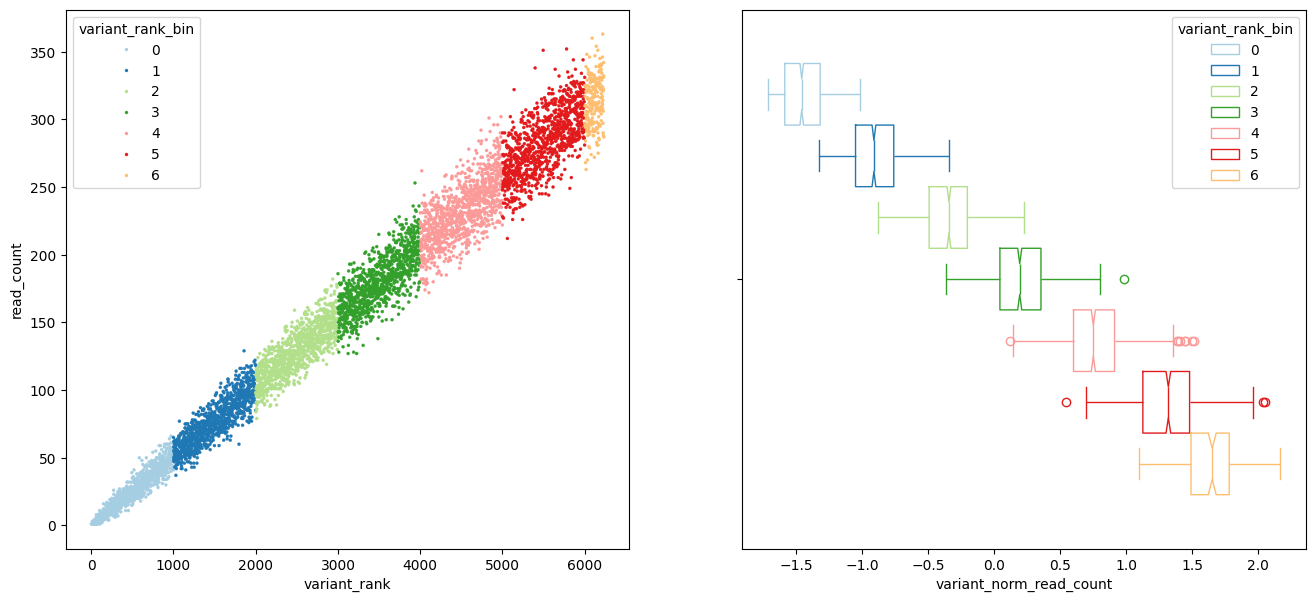

In [81]:
fig,ax = plt.subplots(1, 2, figsize=(16,7))
sns.scatterplot(
    data=ac_df,
    x='variant_rank', y='BarcodeCounts',
    hue='variant_rank_bin',
    palette='Paired',
    s=5, ec=None,
    ax=ax[0]).set(
        ylabel='read_count')
sns.boxplot(
    data=ac_df,
    x='variant_norm_read_count',
    fill=False, notch=True, linewidth=1,
    hue='variant_rank_bin',
    palette='Paired',
    ax=ax[1])
plt.show()

As simulated, the higher the rank of the variant, the more frequently it appeared. In real experimental data, if the pool being sequenced has not undergone selection (say input library) then we expect this distribution to be uniform across all variants.

#### Combinatorial barcode counting with callback

Combinatorial counting is employed when a single or multiple barcode combinations are expected within sequenced reads. `xcount` uses multiple indexes to map the barcodes independently, allowing for flexibility in experimental design. Reads are only discarded if none of the expected barcodes are present, meaning that one or more missing barcodes are tolerated. This approach can accommodate isolated barcodes with their own flanking constants or unique combinations of sub-sequences within a larger assembly through combinatorial methods.

In [82]:
? op.xcount

Signature:
 op.xcount(
    index_files: str,
    pack_file: str,
    count_file: str,
    mapping_type: int = 0,
    barcode_errors: int = -1,
    callback: Optional[Callable[[str, Tuple, int, int], bool]] = None,
    core_count: int = 0,
    memory_limit: float = 0.0,
    verbose: bool = True,
) -> Tuple[pandas.core.frame.DataFrame, dict]
Docstring:
Count barcodes (single or combinatorial) using one or more indices; no associate verification.
Writes a count matrix to disk and returns it as a DataFrame (callbacks available via Python API).

Required Parameters:
    - `index_files` (`str` / `list`): A single (or a list of) index filename(s).
    - `pack_file` (`str`): Pack file path.
    - `count_file` (`str`): Output count matrix filename.

Optional Parameters:
    - `mapping_type` (`int`): Barcode classification (0 for fast, 1 for sensitive) (default: 0).
    - `barcode_errors` (`int`): Maximum errors in barcodes (-1: auto-infer, default: -1).
    - `callback` (`callable`): Custom rea

Let's apply combinatorial counting using both BC1 and BC2 index here.

In [83]:
# Remove previous CC output, if it exists
! rm -f CC.oligopool.xcount.csv

In [84]:
cc_df, _ = op.xcount(
    index_files=['BC1', 'BC2'],     # Map combinations of BC1 and BC2
    pack_file='NGS.oligopool.pack',
    count_file='CC',
    mapping_type=1,
    barcode_errors=-1,
    callback=None,
    core_count=0,
    memory_limit=0.0,
    verbose=True)


[Oligopool Calculator: Analysis Mode - Combinatorial Count]
                                                             
 Required Arguments
     Index File(s): 2 Index Input(s)
                  : BC1.oligopool.index w/ 6,232 Variant(s)
                  : BC2.oligopool.index w/ 6,232 Variant(s) 
      Pack File   : NGS.oligopool.pack w/ 10 Read Packs     
     Count File   : CC.oligopool.xcount.csv             
                                            
 Optional Arguments
   Mapping Type   : Slow / Sensitive Classification
   Barcode Errors : At most 1 Mutations per Barcode (Auto-Inferred)
  Callback Method : None Specified                                  
       Num Cores  : Use 4 out of 4 Cores (Auto-Inferred)
       Mem Limit  : Use 3.00 GB RAM per Core (Auto-Inferred)
                                                             
[Step 2: Enqueing Read Packs]
 Pack Queue  : 10 Read Pack(s) Loaded
 Time Elapsed: 0.01 sec               
                               
[Step 3:

In [85]:
cc_df

,BC1.ID,BC2.ID,CombinatorialCounts
0,ribozyme_0002,ribozyme_0002,1
1,-,ribozyme_0063,1
2,-,ribozyme_0115,1
3,-,ribozyme_0119,2
4,-,ribozyme_0134,1
...,...,...,...
12112,ribozyme_6224,ribozyme_6224,1
12113,ribozyme_6227,ribozyme_6227,1
12114,ribozyme_6228,ribozyme_6228,2
12115,ribozyme_6230,ribozyme_6230,1


As we can see, we have counts of either BC2 or both BC1 and BC2 barcodes from our reads, signifying cleaved and ucleaved products respectively. We can now use this count matrix to compute the activity of the ribozymes.

In [86]:
cc_df['ID'] = cc_df['BC2.ID']
cc_df['count_basis'] = cc_df.apply(lambda x: 'cleaved_reads' if x['BC1.ID'] != x['BC2.ID'] else 'uncleaved_reads', axis=1)
act_df = cc_df.pivot(index='ID', columns='count_basis', values='CombinatorialCounts').fillna(0.).reset_index()
act_df['activity'] = act_df.apply(lambda x: 100. * x.cleaved_reads / (x.cleaved_reads + x.uncleaved_reads), axis=1)
act_df = act_df.merge(ac_df, left_on='ID', right_on='BC2.ID').drop(columns=['BC2.ID']).rename(columns={'BarcodeCounts': 'input_reads'})

In [87]:
act_df.tail(5)

,ID,cleaved_reads,uncleaved_reads,activity,input_reads,AssociationCounts,variant_rank,variant_rank_bin,variant_norm_read_count
6205,ribozyme_6228,320.0,2.0,99.378882,322,322,6228,6,1.727181
6206,ribozyme_6229,331.0,0.0,100.000000,331,331,6229,6,1.823750
6207,ribozyme_6230,341.0,1.0,99.707602,342,342,6230,6,1.941779
6208,ribozyme_6231,331.0,1.0,99.698795,332,332,6231,6,1.834480
6209,ribozyme_6232,287.0,0.0,100.000000,287,287,6232,6,1.351635


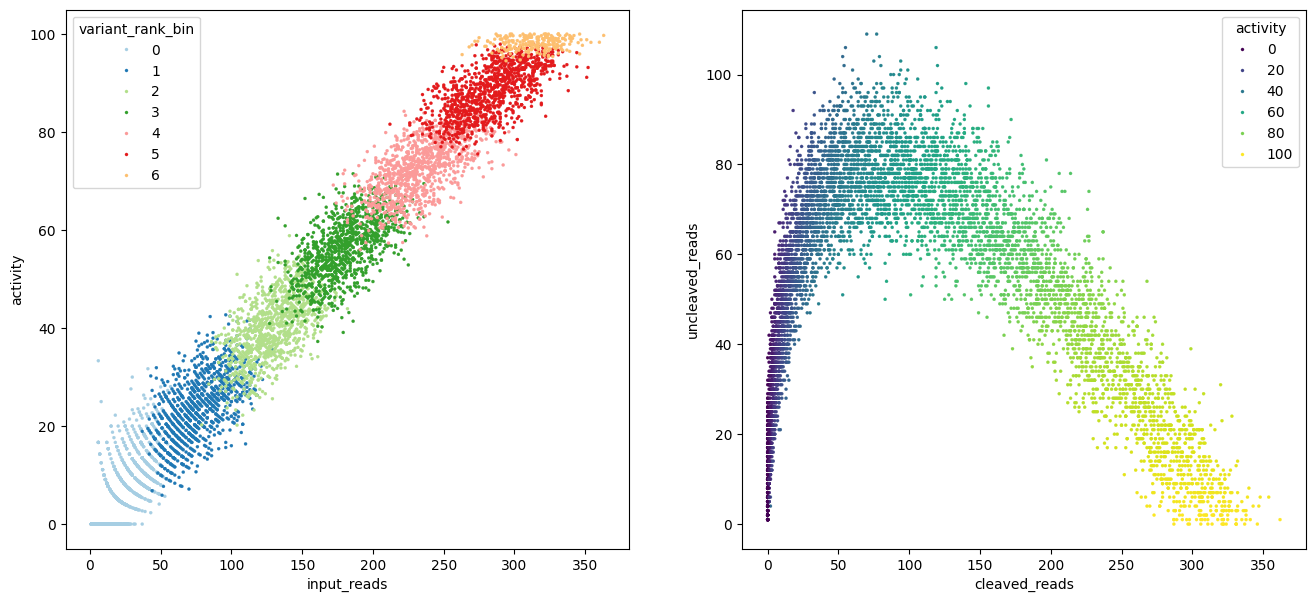

In [88]:
fig,ax = plt.subplots(1, 2, figsize=(16,7))
sns.scatterplot(
    data=act_df,
    x='input_reads', y='activity',
    hue='variant_rank_bin',
    palette='Paired',
    s=5, ec=None,
    ax=ax[0])
sns.scatterplot(
    data=act_df,
    x='cleaved_reads', y='uncleaved_reads',
    hue='activity',
    palette='viridis',
    s=5, ec=None,
    ax=ax[1])
plt.show()

As simulated, the higher the rank of the variant the more input reads it had, which is proportional to the inferred activity. This is seen in the plot on the left. The right plot shows those high activity variants having a larger proportion of cleaved reads relative to their uncleaved read counts.

Finally, let us use a callback function to filter out any reads not matching our simulated criteria of the cleavage location being the 10th base of the variant.

In [89]:
df.head(5)

,ID,EcoRI,OrangeForwardPrimer,BC1,Variant,PinkForwardPrimer,BC2,YellowReversePrimer,AatIIPadded,Spacer
0,ribozyme_0001,GAATTC,CGGACGTTATGGTTGGGGTT,TAGTCAAGCGC,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GGTGCAAGGTTGTTGGGGAA,CTTGTCAGCCC,ATCTATCTAACCGCCCCCCG,GACGTCGCG,CCTAAATTTGGAG
1,ribozyme_0002,GAATTC,CGGACGTTATGGTTGGGGTT,CATTATATGTC,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GGTGCAAGGTTGTTGGGGAA,CTTTGCTGCCG,ATCTATCTAACCGCCCCCCG,GACGTCGCG,CAG
2,ribozyme_0003,GAATTC,CGGACGTTATGGTTGGGGTT,TCGGCGCGTGA,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GGTGCAAGGTTGTTGGGGAA,TGGGTAGTAAT,ATCTATCTAACCGCCCCCCG,GACGTCGCG,CCTAAATTTGGAG
3,ribozyme_0004,GAATTC,CGGACGTTATGGTTGGGGTT,GGAGATGATAG,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GGTGCAAGGTTGTTGGGGAA,GCTAGGGCTTT,ATCTATCTAACCGCCCCCCG,GACGTCGCG,GCGCTGAGC
4,ribozyme_0005,GAATTC,CGGACGTTATGGTTGGGGTT,AGTGCATGTCC,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GGTGCAAGGTTGTTGGGGAA,CTCCGCGGTGG,ATCTATCTAACCGCCCCCCG,GACGTCGCG,ACTCTGTAAATC


To do this we will observe a couple of things. First, the cleaved reads will only contain BC2 in them. Second, the subsequence specified in the `Variant` column will appear partially in the read. Infact as simulated, the cleaved reads will contain part of the variant, the whole of `PinkForwardPrimer` and `BC2`.

Both `xcount` and `acount` allows us to use the information from the reads to concurrently do our own calculations on the reads and to signal to the counting algorithm whether to use the read as part of the counting process.

In [90]:
# Remove previous CC output, if it exists
! rm -f CCC.oligopool.xcount.csv

In [91]:
# Build a shared dictionary for our callback below (detailed later)
ribozyme_memory = Manager().dict(zip(df.ID, df.Variant))

In [92]:
# Callback logic
def filter_non_cleaved_reads(ribozyme_memory, pink_forward_primer):
    '''Outer wrapper to give our method some memory.'''

    def wrapped(read, ID, count, coreid):
        '''Inner closure to filter reads.

        Note that `xcount` and `acount` callbacks must have this signature.
        See help(op.acount) or help(op.xcount) for details.'''

        # If more than one barcode present, we are not going to do anything with it, because
        # it implies an uncleaved read. We only want to use BC2-exclusive cleaved reads.
        if ID[0] is None and not ID[1] is None:
            # The first ID will be None during `xcount` because we will compute BC1 x BC2

            # Extract ribozyme ID
            ribozyme_id = ID[1]

            # The constant primer must be present for acceptance
            if pink_forward_primer in read:

                # Extract ribozyme fragment
                ribozyme_fragment = read[:read.index(pink_forward_primer)]
                # Fetch the expected full variant
                ribozyme_full = ribozyme_memory[ribozyme_id]

                # Figure out where the fragment starts in the variant
                if ribozyme_fragment in ribozyme_full:
                    ribozyme_start = ribozyme_full.index(ribozyme_fragment)
                    # This index must be 10 or greater for cleaved product-based read
                    return ribozyme_start >= 10

            '''
            Note: Here we are using exact matching logic. In reality we might want to do
                  some alignment based extraction of our fragments to be error-aware.
            '''

        # Reject the read for counting ... didn't pass filtering due to one or more reasons
        return False

    # Return Wrapped Processor
    return wrapped

Virtually any logic can be executed concurrently with counting, as long as the callback returns a boolean. If a callback function returns `False`, the counting function will not use the reads for counting.

If we need to, we can also record additional results from our callback calculations via [shared data structures](https://superfastpython.com/multiprocessing-manager-example/) such as a `Manager` `dict` or `list`. This is useful, for example, if we wanted to extract and store the location of cleavage sites in reads (instead of assuming it to be the 10th base in the designed variants). Another similar use case is extracting transcription start sites for a library of designed promoters.

> **Note** The `Manager` `dict` here ensures that all parallel callback processes during counting will have access to the same exact dictionary, controlled and synchronized by a separate `Manager` instance. This allows us to modify the content of the managed dictionary in one process and have the changes be reflected in callbacks executed by other counting processes in parallel. This also allows us to easily gather and store additional results, in parallel, to a persistent and centralized dictionary for post-counting analysis.

In [93]:
# Notice that we need to use the outer wrapper as callback
cc_callback = filter_non_cleaved_reads(
    ribozyme_memory=ribozyme_memory,
    pink_forward_primer=df.PinkForwardPrimer.values[0])

Don't worry, if our callback fails, the return stats dictionary will contain the inputs for which our callback failed and we can debug accordingly.

In [94]:
_, stats = op.xcount(
    index_files=['BC1', 'BC2'],
    pack_file='NGS.oligopool.pack',
    count_file='CCC',
    mapping_type=1,
    barcode_errors=-1,
    callback=cc_callback,
    core_count=0,
    memory_limit=0.0,
    verbose=False) # Silent Mode

In [95]:
pprint(stats)

{'basis': 'solved',
 'input_rows': 10,
 'module': 'xcount',
 'output_rows': 5922,
 'status': True,
 'step': 4,
 'step_name': 'writing-count-matrix',
 'vars': {'analyzed_reads': 1000001,
          'callback_error': False,
          'callback_false_reads': 333243,
          'experiment_reads': 666758,
          'failed_inputs': None,
          'incalc_reads': 0,
          'low_complex_reads': 0,
          'phiX_reads': 0},
 'warns': {}}


We can see that our callback filtering function rejected a lot of reads, as recorded in `callback_false_reads` key in the stats dictionary. Rest of the reads were cleaved and were accepted for counting.

That concludes our `Analysis Mode` walkthrough! Let us remove all the `Analysis Mode` objects.

In [96]:
! rm -f BC*.oligopool.index NGS.oligopool.pack AC.oligopool.acount.csv CC*.oligopool.xcount.csv

### Conclusion

`Oligopool Calculator` offers a comprehensive solution for designing and analyzing genetic part libraries using oligopools. Its `Design Mode` automates the creation of oligopool architectures for various genetic elements, enabling synthetic biologists to efficiently compose and assemble complex libraries. The `Analysis Mode` provides flexible, barcode-based counting of NGS reads for variant characterization, with options for custom analysis. We hope this tool empowers researchers to fully leverage oligopools in engineering and screening large libraries of functional genetic parts, facilitating the development of accurate models of part function. It is designed to streamline the entire process from design to analysis, and we hope it will be a useful resource for synthetic biology research.

---